In [1]:
import collections
collections.Iterable = collections.abc.Iterable
from prepare_model_env import *

In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:
# define network parameters
n_classes = 1
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [7]:
# dice loss = 1 - (2 * intersection) / (union + intersection)
dice_loss = sm.losses.DiceLoss()
# Binary Focal Loss = -α * (1 - p)^γ * log(p) - (1 - α) * p^γ * log(1 - p)
# α is a weighting factor to balance the contribution of the two classes. It is typically set to the inverse of the class frequencies.
# p is the predicted probability of the positive class.
# γ is the focusing parameter that controls how much the loss is focused on hard examples.
# When γ = 0, the focal loss becomes the standard binary cross-entropy loss. As γ increases,
# the loss focuses more on hard examples, i.e., examples that are misclassified with high confidence.
focal_loss = sm.losses.BinaryFocalLoss(gamma=3.5)

total_loss = dice_loss + 1.5*focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer='Adam', loss=total_loss, metrics=metrics)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_2[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                         

In [19]:
# load dataset
dataset = Dataset(dataset_dir="../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/dataset/", augmentation=get_training_augmentation())

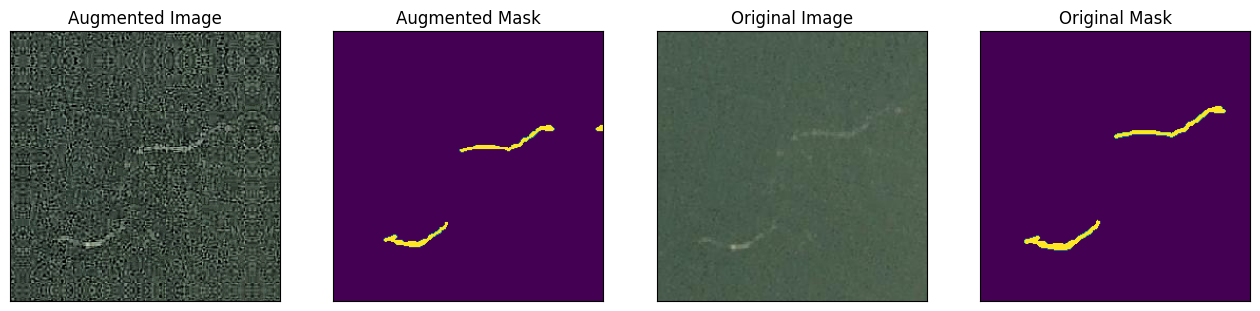

In [21]:
image, mask = dataset[99] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[99],
    original_mask= dataset.y[99]
)

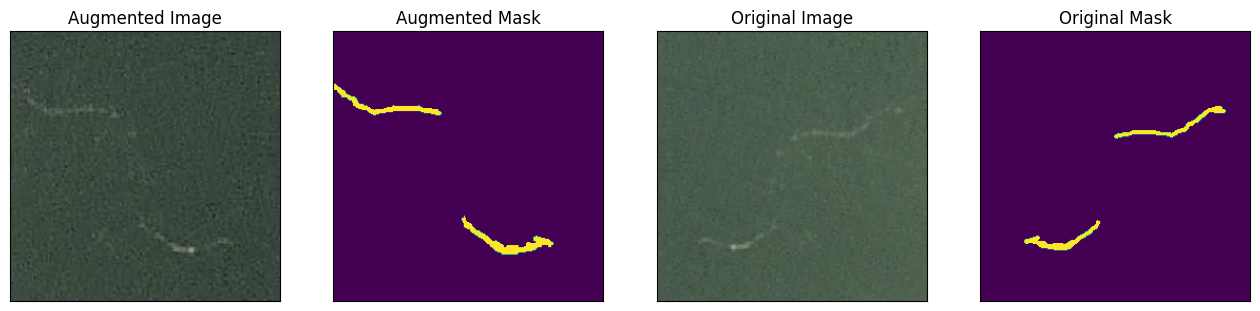

In [22]:
image, mask = dataset[99] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[99],
    original_mask= dataset.y[99]
)

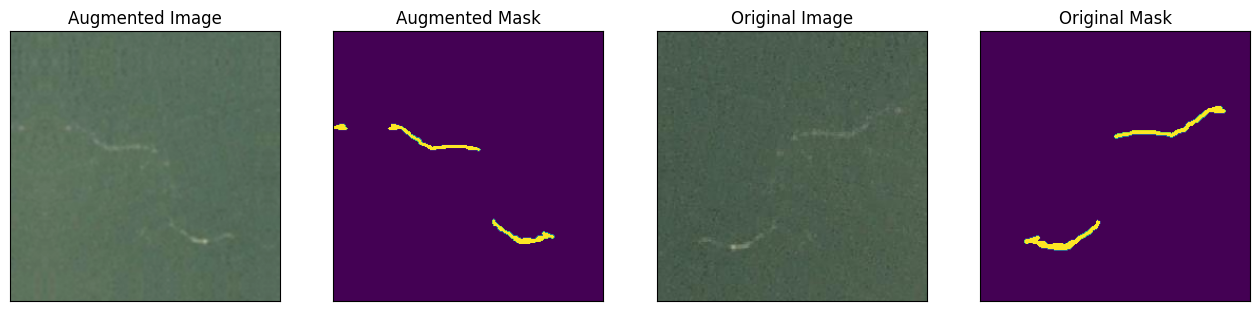

In [23]:
image, mask = dataset[99] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[99],
    original_mask= dataset.y[99]
)

In [24]:
# train test split
x_train, x_val, y_train, y_val = dataset.split_data()

# pre processing
x_train, y_train, x_val, y_val = dataset.pre_process(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

# define dataloader and datasets objects for train and validation data
train_dataset = Dataset(
    x=x_train,
    y=y_train,
    augmentation=get_training_augmentation()
)

valid_dataset = Dataset(
    x=x_val,
    y=y_val,
    augmentation=get_training_augmentation()
)

In [25]:
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generate=10)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False, generate=10)

In [26]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_efficientnetb3_1.h5', save_weights_only=True, save_best_only=True, mode='min', monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(),
]

In [27]:
tf.config.run_functions_eagerly(True)

In [28]:
history = model.fit(
    x=train_dataloader.dataset.x,
    y=train_dataloader.dataset.y,
    shuffle=train_dataloader.shuffle,
    batch_size=train_dataloader.batch_size,
    callbacks=callbacks,
    epochs=EPOCHS,
    validation_data=(valid_dataloader.dataset.x, valid_dataloader.dataset.y),
)

Epoch 1/40


D:\anaconda\envs\segmentation_run\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


200/200 [==============================] - 1165s 6s/step - loss: 0.5259 - iou_score: 0.5365 - val_loss: 0.4863 - val_iou_score: 0.4359 - lr: 0.0010
Epoch 2/40
200/200 [==============================] - 1137s 6s/step - loss: 0.1977 - iou_score: 0.7112 - val_loss: 0.2928 - val_iou_score: 0.5972 - lr: 0.0010
Epoch 3/40
200/200 [==============================] - 1167s 6s/step - loss: 0.1602 - iou_score: 0.7567 - val_loss: 0.2600 - val_iou_score: 0.6267 - lr: 0.0010
Epoch 4/40
200/200 [==============================] - 1146s 6s/step - loss: 0.1360 - iou_score: 0.7884 - val_loss: 0.2615 - val_iou_score: 0.6343 - lr: 0.0010
Epoch 5/40
200/200 [==============================] - 1220s 6s/step - loss: 0.1260 - iou_score: 0.8022 - val_loss: 0.2441 - val_iou_score: 0.6466 - lr: 0.0010
Epoch 6/40
200/200 [==============================] - 1195s 6s/step - loss: 0.1174 - iou_score: 0.8147 - val_loss: 0.2320 - val_iou_score: 0.6599 - lr: 0.0010
Epoch 7/40
200/200 [==============================] - 115

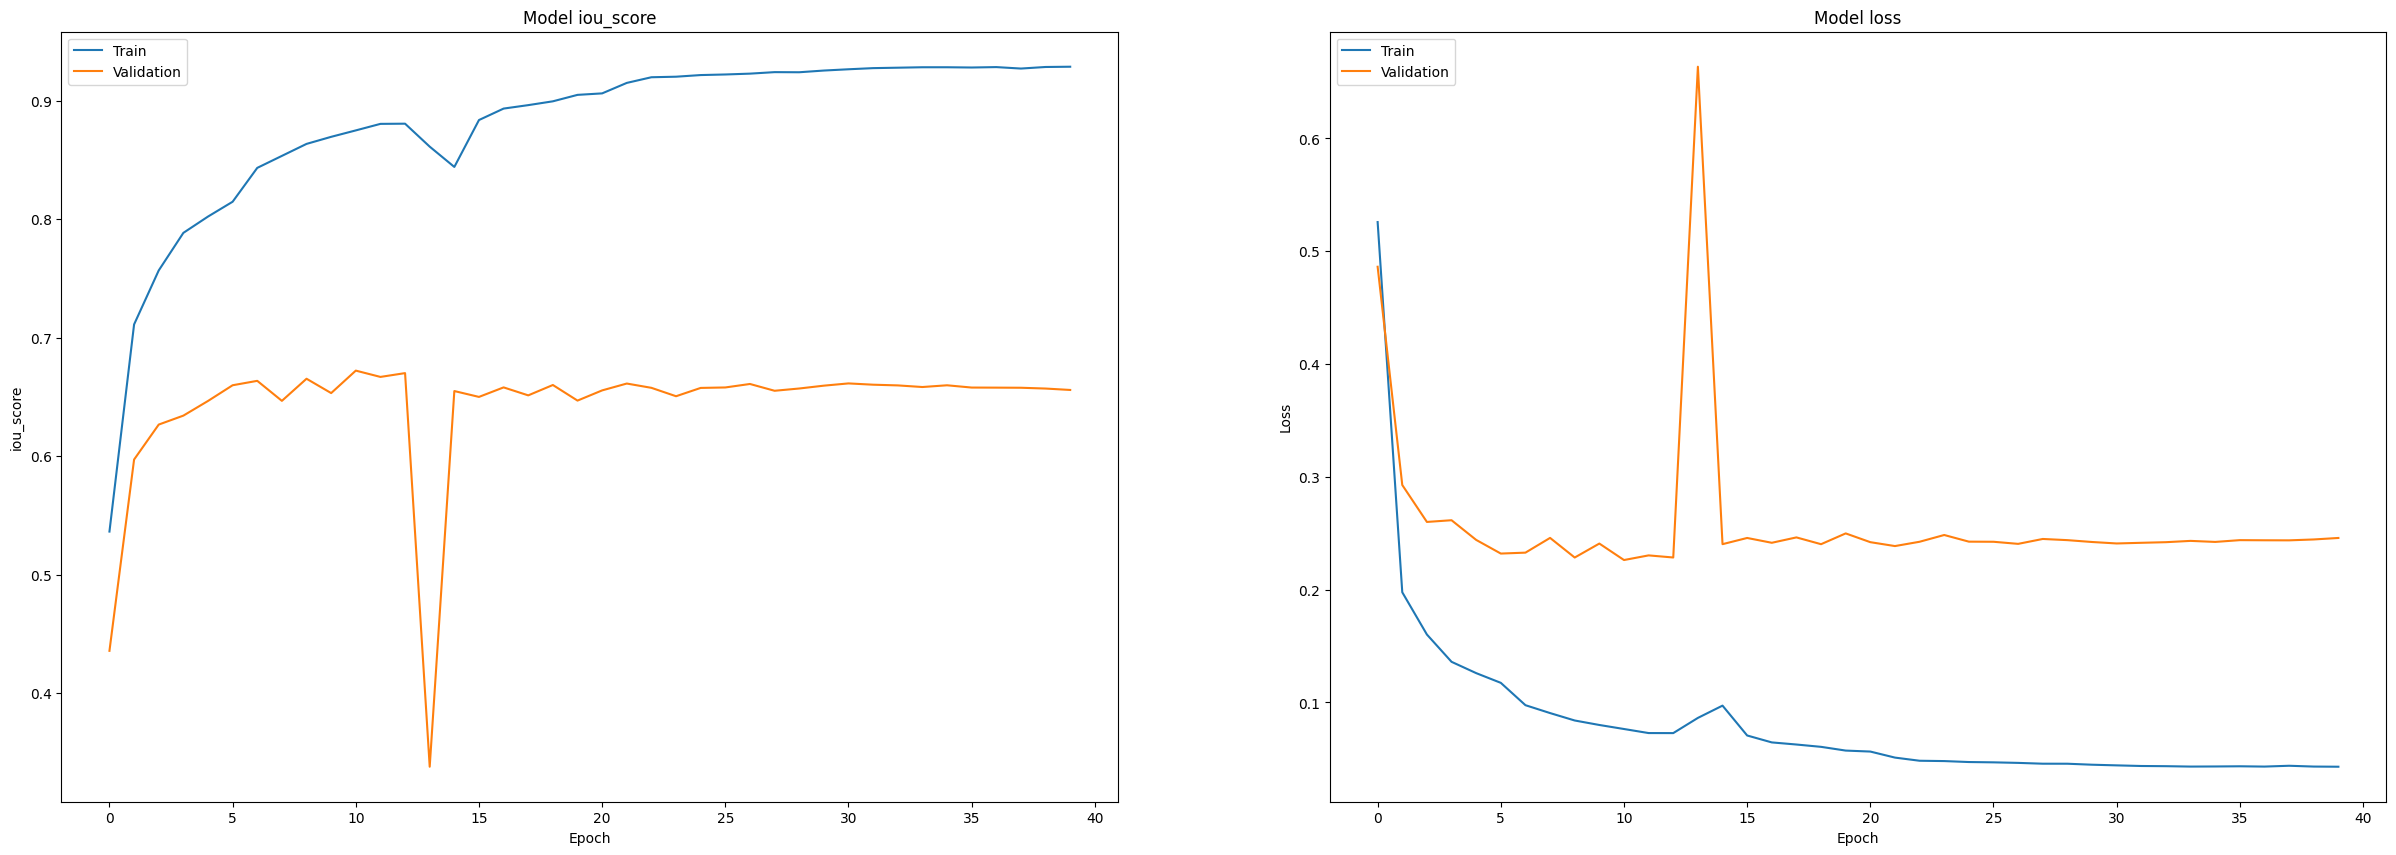

In [30]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
model.load_weights("best_model_efficientnetb3_1.h5")

1/1 [==============================] - 0s 372ms/step


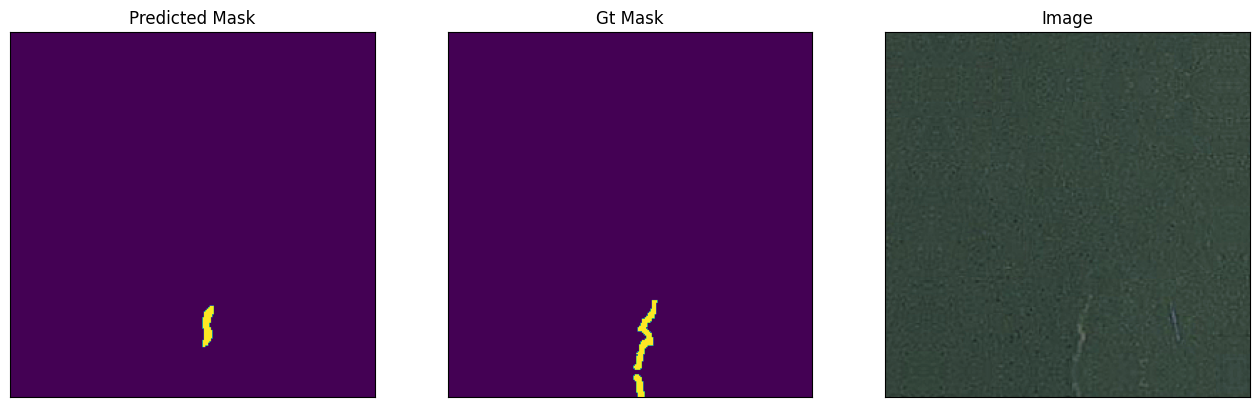

1/1 [==============================] - 0s 341ms/step


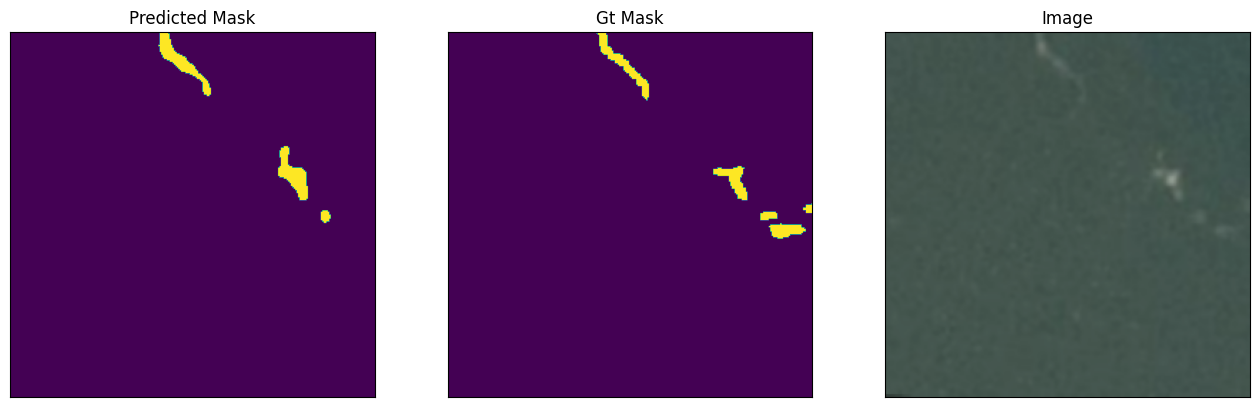

1/1 [==============================] - 0s 304ms/step


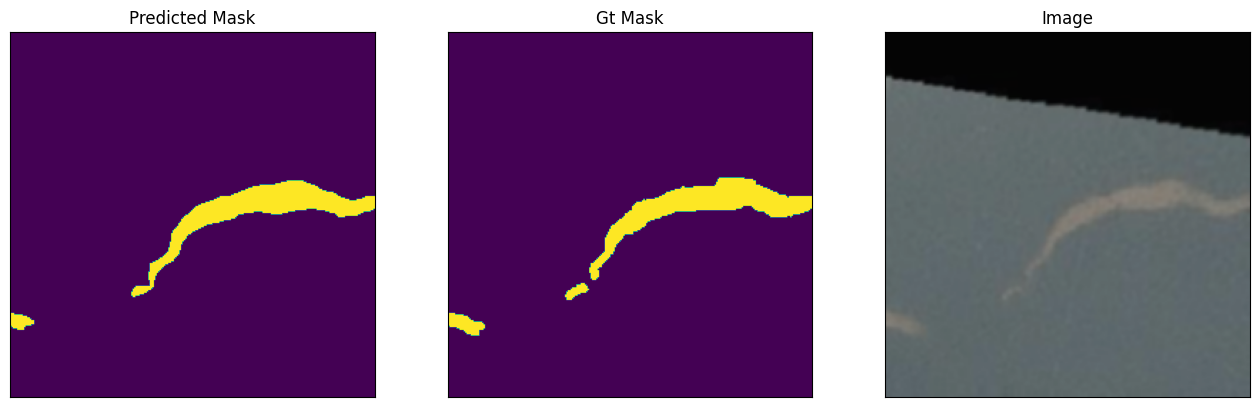

1/1 [==============================] - 0s 335ms/step


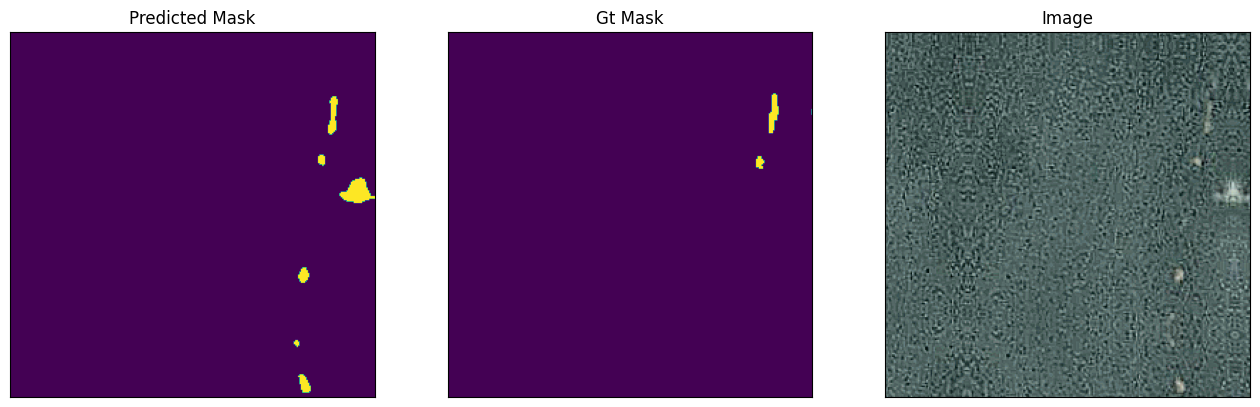

1/1 [==============================] - 0s 322ms/step


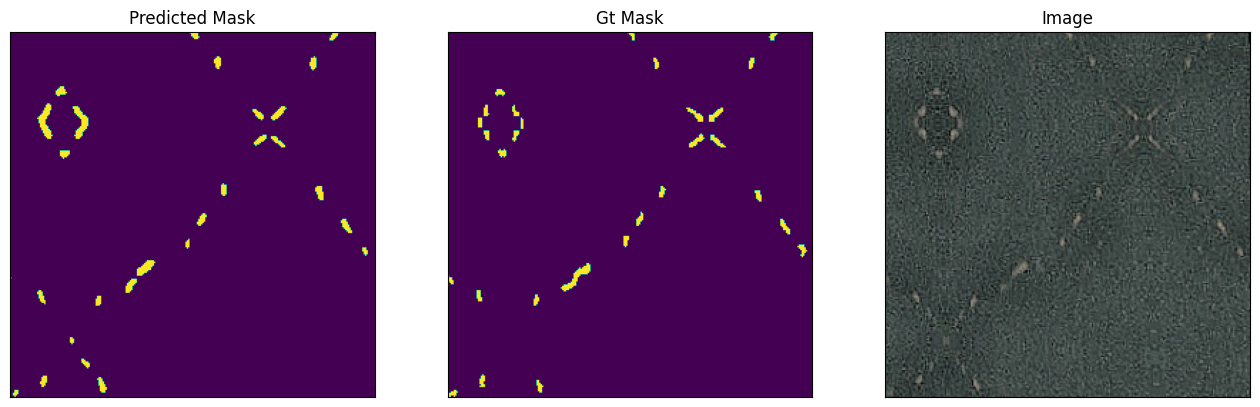

1/1 [==============================] - 0s 320ms/step


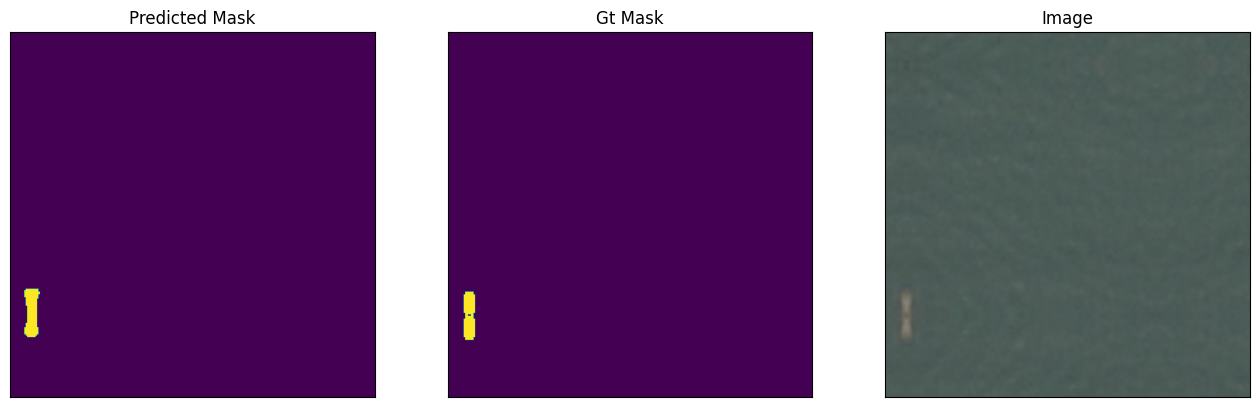

1/1 [==============================] - 0s 319ms/step


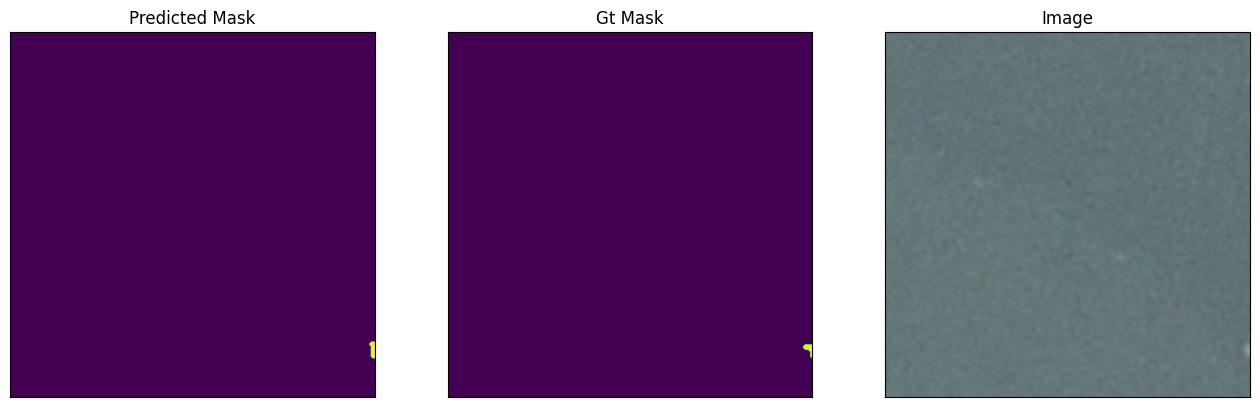

1/1 [==============================] - 0s 328ms/step


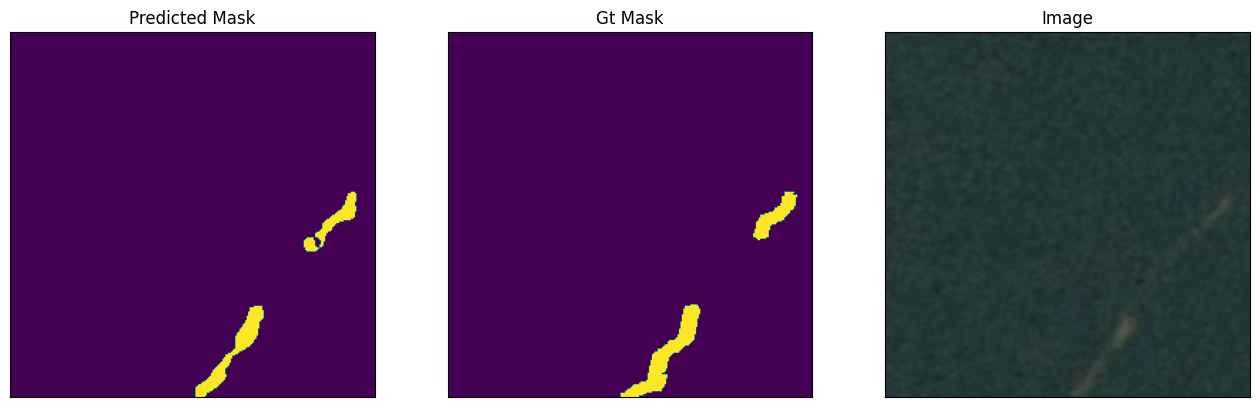

1/1 [==============================] - 0s 333ms/step


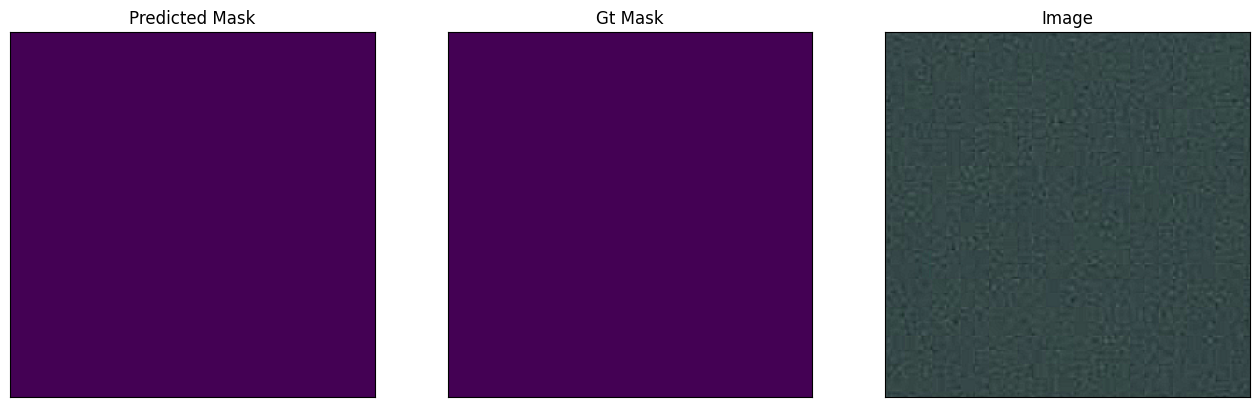

1/1 [==============================] - 0s 330ms/step


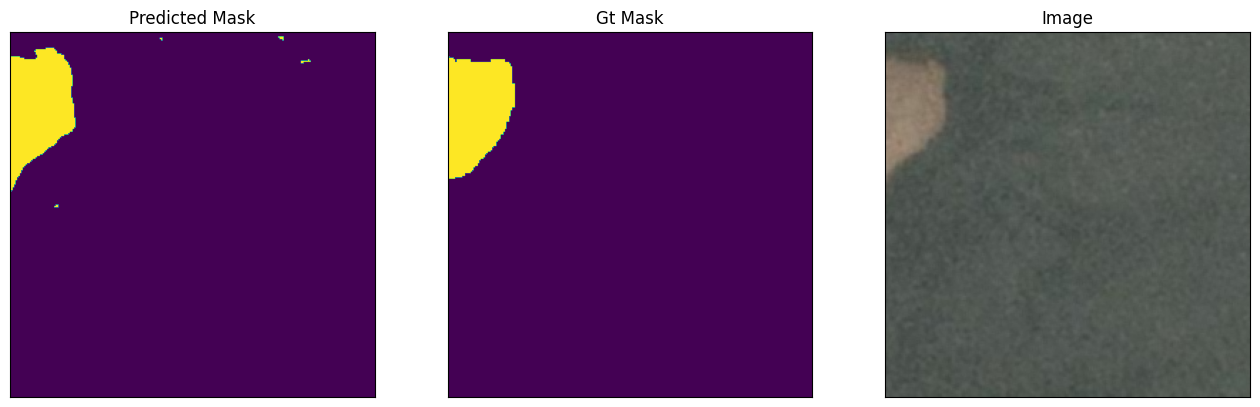

In [41]:
# checking few predictions from the valid dataset
for i in range(300, 310):
  prediction = predict(model, valid_dataloader.dataset.x[i])
  visualize(
      predicted_mask=prediction,
      gt_mask=valid_dataloader.dataset.y[i],
      image=valid_dataloader.dataset.x[i]
  )

1/1 [==============================] - 2s 2s/step


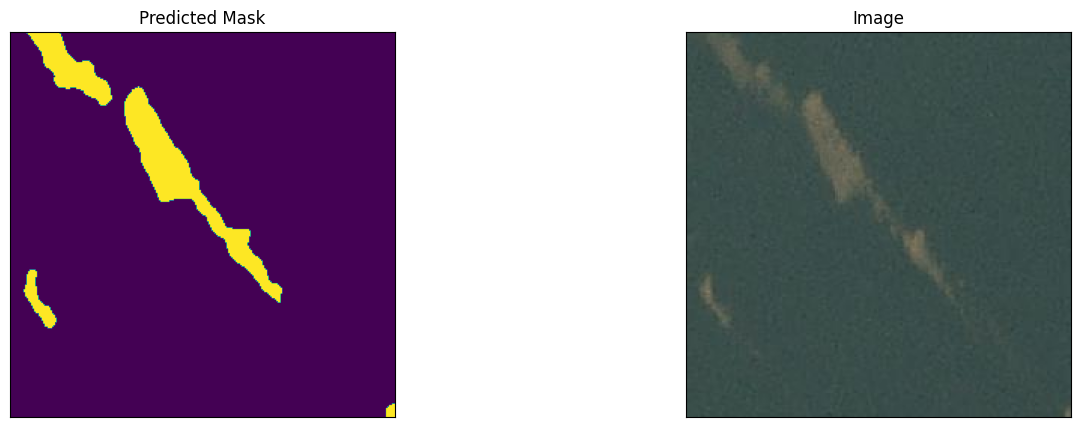

1/1 [==============================] - 0s 148ms/step


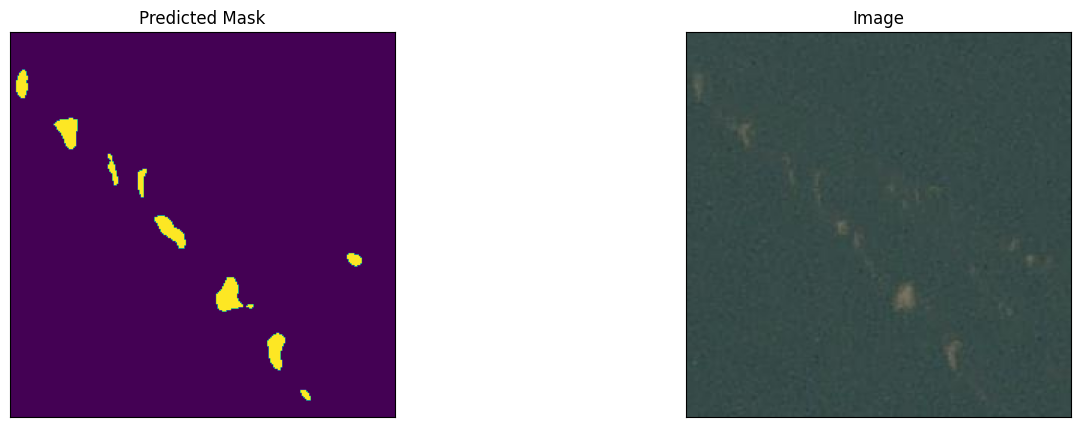

1/1 [==============================] - 0s 111ms/step


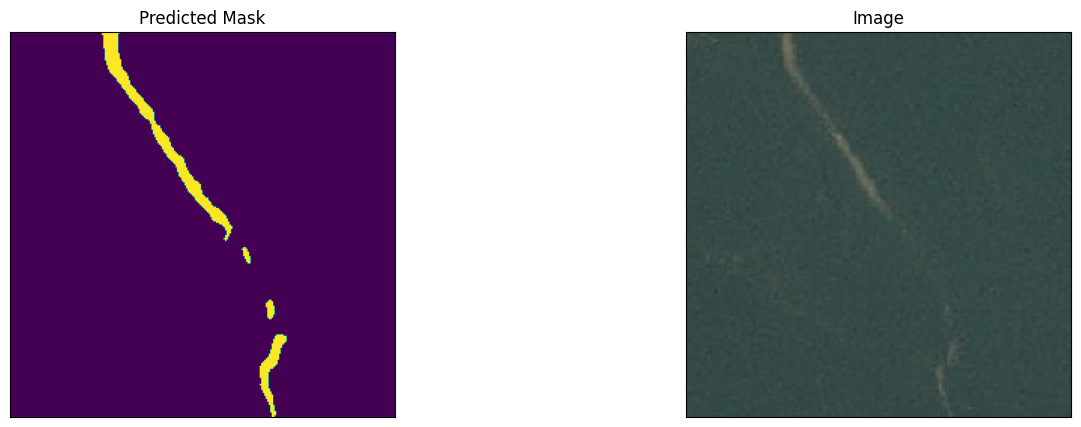

1/1 [==============================] - 0s 145ms/step


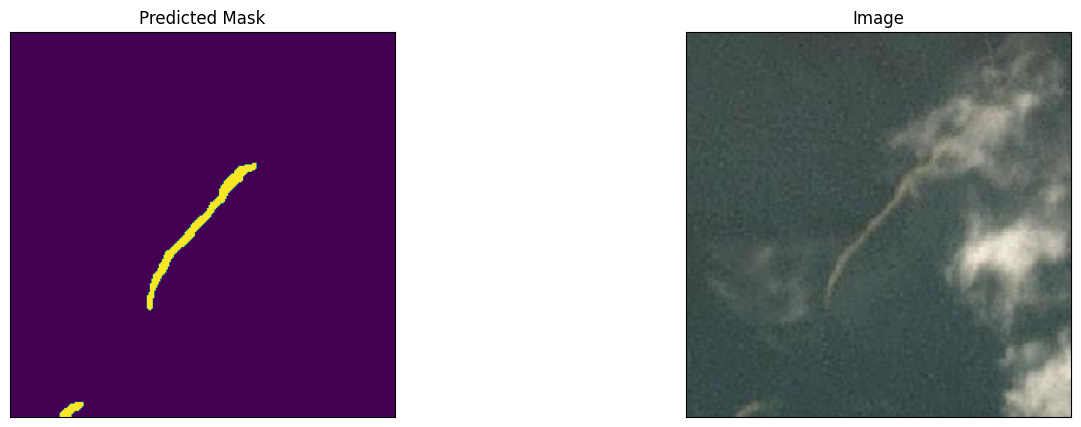

1/1 [==============================] - 0s 157ms/step


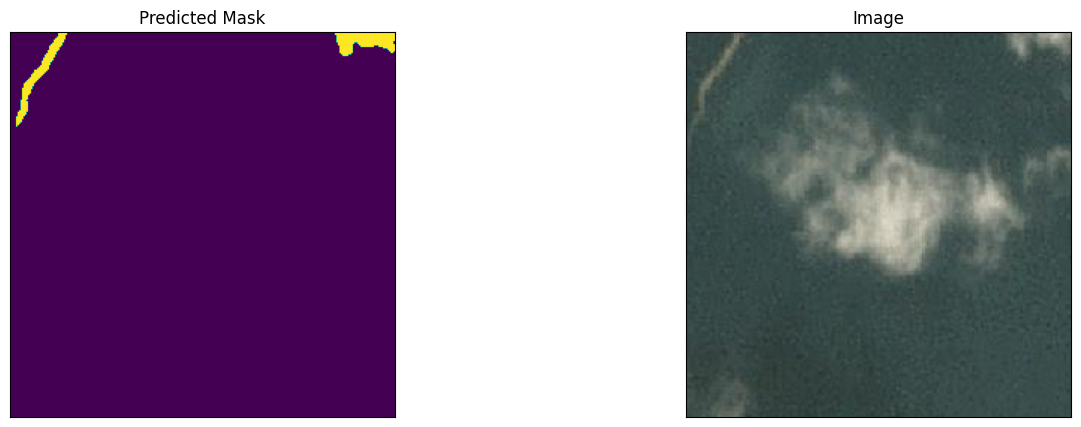

1/1 [==============================] - 0s 118ms/step


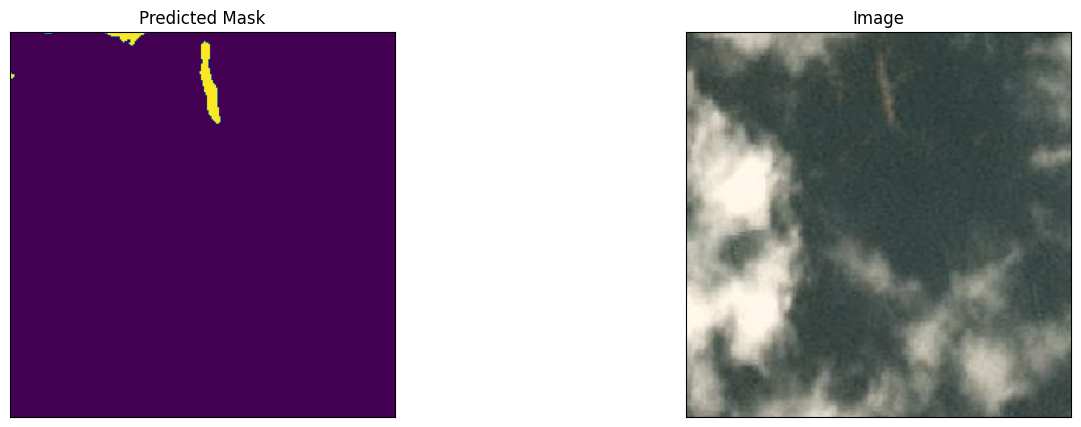

1/1 [==============================] - 0s 143ms/step


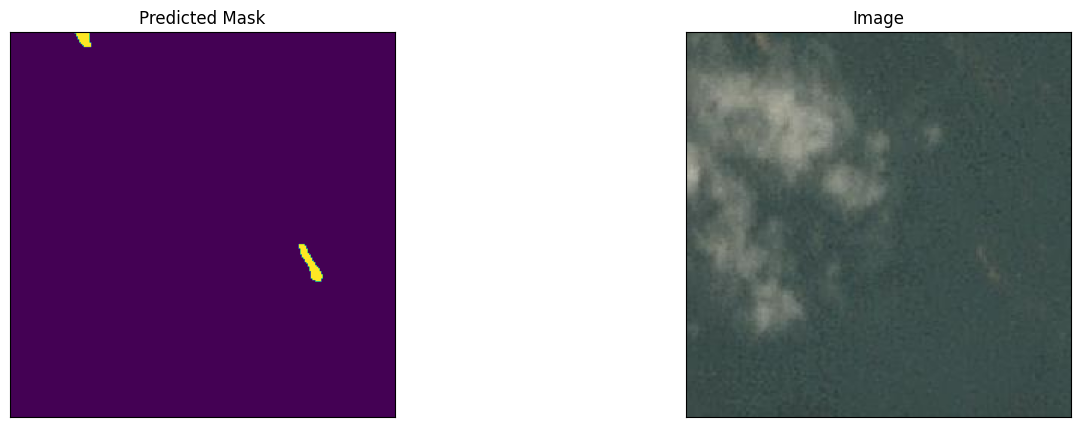

1/1 [==============================] - 0s 107ms/step


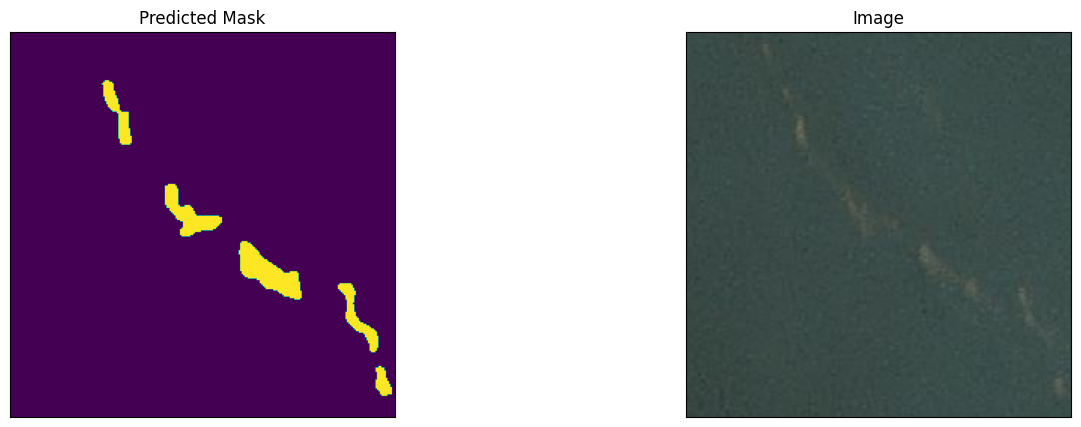

1/1 [==============================] - 0s 147ms/step


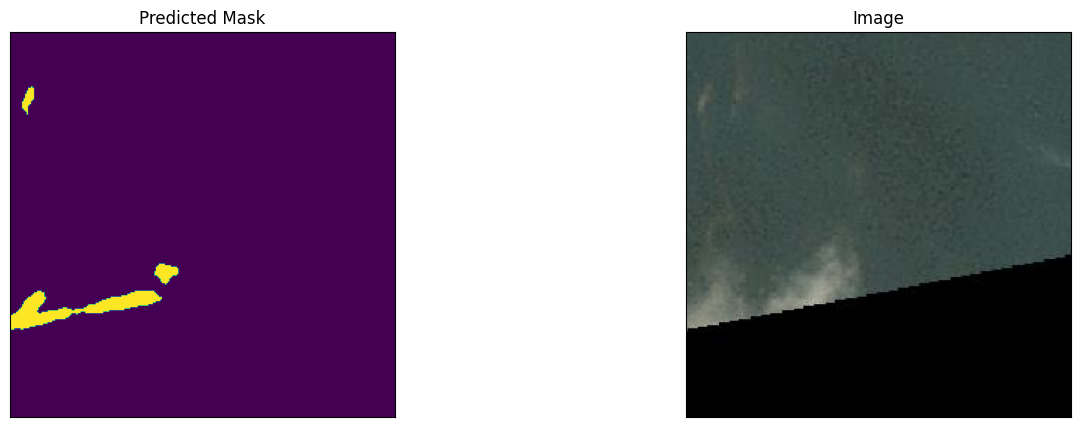

1/1 [==============================] - 0s 113ms/step


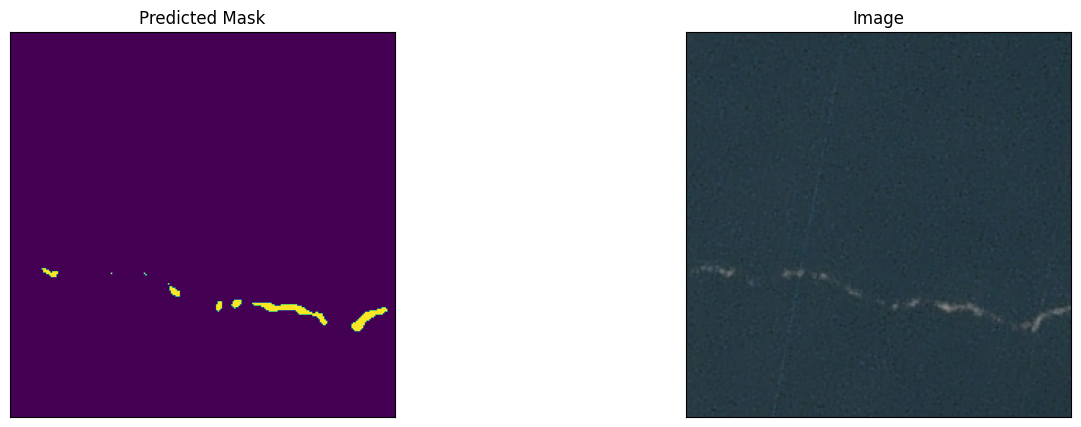

In [9]:
## checking predictions on new unannotated images
dataset_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/unannotated_images/"
test_images = []
for filename in os.listdir(dataset_dir):
    image_path = os.path.join(dataset_dir, filename)
    test_images.append(io.imread(image_path))

for test_image in test_images:
    prediction = predict(model=model, image=test_image)
    visualize(
      predicted_mask=prediction,
      image=test_image
    )